# 03 — CNN Text Classification (Word2Vec Embeddings)

This notebook builds a **1D Convolutional Neural Network** for fake news detection using pretrained Word2Vec embeddings as the embedding layer. CNNs learn to detect local patterns (n-gram-like features) in the embedding space, making them more expressive than mean-pooled Word2Vec vectors.

**Outline**
1. Load data  
2. Tokenise & pad sequences  
3. Build Word2Vec embedding matrix  
4. Build and compile CNN model  
5. Train with EarlyStopping  
6. Plot training curves  
7. Evaluate — metrics, confusion matrix, ROC, PR curve  
8. LIME explainability  
9. Error analysis  
10. Save model  

In [ ]:
!pip install numpy pandas matplotlib seaborn nltk scikit-learn tensorflow gensim lime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 275.7/275.7 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lime: filename=lime-0.2.0.1-py3-none-any.whl size=283834 sha256=127d80610181a7f92dcf604909a92977f1a7c940f99febead3522bf6141e54d9
  Stored in directory: /root/.cache/pip/wheels/e7/5d/0e/4b4fff9a47468fed5633211fb3b76d1db43fe806a17fb7486a
Successfully built lime


In [ ]:
import os, re, string, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

import nltk
from nltk.corpus import stopwords

from sklearn.model_selection import train_test_split
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc, precision_recall_curve
)

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, models, callbacks

import gensim.downloader as api

warnings.filterwarnings('ignore')
sns.set_theme(style='whitegrid')
plt.rcParams['figure.dpi'] = 120

for r in ['punkt', 'punkt_tab', 'stopwords']:
    try:
        nltk.data.find(f'tokenizers/{r}' if 'punkt' in r else f'corpora/{r}')
    except LookupError:
        nltk.download(r, quiet=True)

MODELS_DIR = '../models'
os.makedirs(MODELS_DIR, exist_ok=True)

print(f'TF version: {tf.__version__}')

TF version: 2.19.0


---
## 1. Load Data

In [ ]:
df = pd.read_csv('cleaned_isot.csv')
print(f'Loaded {len(df):,} rows')

X = df['clean_text'].values
y = df['class'].values

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)
print(f'Train: {len(X_train):,}  Test: {len(X_test):,}')

Loaded 44,889 rows
Train: 35,911  Test: 8,978


---
## 2. Tokenise & Pad Sequences

We use Keras's `Tokenizer` to build a vocabulary of the top 35,000 words, then encode each article as an integer sequence and pad/truncate to a fixed length of 430 tokens (the ~95th percentile article length in our dataset).

In [ ]:
MAX_WORDS = 35_000
MAX_LEN   = 430

tokenizer = Tokenizer(num_words=MAX_WORDS, oov_token='<OOV>')
tokenizer.fit_on_texts(X_train)  # fit ONLY on training data

X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=MAX_LEN, padding='post', truncating='post')
X_test_seq  = pad_sequences(tokenizer.texts_to_sequences(X_test),  maxlen=MAX_LEN, padding='post', truncating='post')

vocab_size = min(MAX_WORDS, len(tokenizer.word_index) + 1)
print(f'Vocab size  : {vocab_size:,}')
print(f'Sequence shape (train): {X_train_seq.shape}')

Vocab size  : 35,000
Sequence shape (train): (35911, 430)


---
## 3. Build Word2Vec Embedding Matrix

We load Google News Word2Vec (300d) and build an embedding matrix where row `i` is the Word2Vec vector for the word with tokenizer index `i`. Words not found in Word2Vec are left as zero vectors.

In [ ]:
print('Loading Word2Vec...')
wv = api.load('word2vec-google-news-300')
EMBED_DIM = 300

embedding_matrix = np.zeros((vocab_size, EMBED_DIM))
hits, misses = 0, 0

for word, idx in tokenizer.word_index.items():
    if idx >= vocab_size:
        continue
    if word in wv:
        embedding_matrix[idx] = wv[word]
        hits += 1
    else:
        misses += 1

coverage = hits / (hits + misses) * 100
print(f'Embedding matrix: {embedding_matrix.shape}')
print(f'Word2Vec coverage: {hits:,} hits / {hits+misses:,} words ({coverage:.1f}%)')

Loading Word2Vec...
[==================================================] 100.0% 1662.8/1662.8MB downloaded
Embedding matrix: (35000, 300)
Word2Vec coverage: 13,271 hits / 34,999 words (37.9%)


---
## 4. Build CNN Model

Architecture:
- **Embedding** (pretrained Word2Vec, frozen)
- **Conv1D** (128 filters, kernel=3) — detects local trigram patterns
- **MaxPooling1D** (pool=5) — reduces sequence length
- **Flatten** → **Dense(128, relu)** → **Dropout(0.3)** → **Dense(1, sigmoid)**

In [ ]:
def build_cnn(vocab_size, embed_dim, embed_matrix, max_len):
    inp = layers.Input(shape=(max_len,))
    x = layers.Embedding(
        input_dim=vocab_size,
        output_dim=embed_dim,
        weights=[embed_matrix],
        trainable=False,
        name='embedding'
    )(inp)
    x = layers.Conv1D(128, kernel_size=3, activation='relu', name='conv1d')(x)
    x = layers.MaxPooling1D(pool_size=5, name='maxpool')(x)
    x = layers.Flatten(name='flatten')(x)
    x = layers.Dense(128, activation='relu', name='dense1')(x)
    x = layers.Dropout(0.3, name='dropout')(x)
    out = layers.Dense(1, activation='sigmoid', name='output')(x)
    model = models.Model(inp, out)
    return model

cnn = build_cnn(vocab_size, EMBED_DIM, embedding_matrix, MAX_LEN)
cnn.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss='binary_crossentropy',
    metrics=['accuracy']
)
cnn.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 430)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 430, 300)       │    10,500,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d (Conv1D)                 │ (None, 428, 128)       │       115,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ maxpool (MaxPooling1D)          │ (None, 85, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 10880)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense1 (Dense)                  │ (None, 128)            │     1,392,768 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 1)              │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 12,008,225 (45.81 MB)

 Trainable params: 1,508,225 (5.75 MB)

 Non-trainable params: 10,500,000 (40.05 MB)

---
## 5. Train

We train for up to 10 epochs with EarlyStopping (patience=3) monitoring validation loss. The best weights are automatically restored.

In [ ]:
early_stop = callbacks.EarlyStopping(
    monitor='val_loss', patience=3, restore_best_weights=True, verbose=1
)

history = cnn.fit(
    X_train_seq, y_train,
    epochs=10,
    batch_size=128,
    validation_split=0.2,
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 17s 45ms/step - accuracy: 0.7527 - loss: 0.4743 - val_accuracy: 0.9620 - val_loss: 0.0948
Epoch 2/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9794 - loss: 0.0681 - val_accuracy: 0.9761 - val_loss: 0.0598
Epoch 3/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9888 - loss: 0.0306 - val_accuracy: 0.9841 - val_loss: 0.0527
Epoch 4/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9974 - loss: 0.0089 - val_accuracy: 0.9839 - val_loss: 0.0523
Epoch 5/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 5s 21ms/step - accuracy: 0.9991 - loss: 0.0049 - val_accuracy: 0.9868 - val_loss: 0.0532
Epoch 6/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 0.9996 - loss: 0.0020 - val_accuracy: 0.9859 - val_loss: 0.0543
Epoch 7/10
225/225 ━━━━━━━━━━━━━━━━━━━━ 4s 18ms/step - accuracy: 1.0000 - loss: 6.7193e-04 - val_accuracy: 0.9854 - val_loss: 0.0560
Epoch 7: early stopping
Restoring model weights from the end of the best epoch: 4.


---
## 6. Training Curves

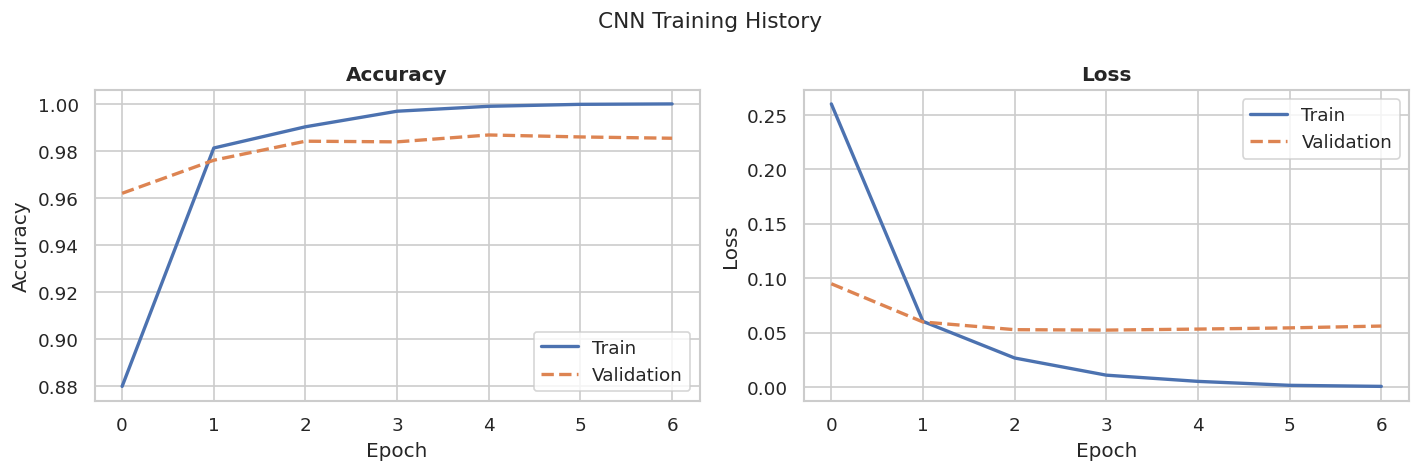

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.plot(history.history['accuracy'],     label='Train', lw=2)
ax1.plot(history.history['val_accuracy'], label='Validation', lw=2, linestyle='--')
ax1.set_title('Accuracy', fontweight='bold')
ax1.set_xlabel('Epoch'); ax1.set_ylabel('Accuracy')
ax1.legend()

ax2.plot(history.history['loss'],     label='Train', lw=2)
ax2.plot(history.history['val_loss'], label='Validation', lw=2, linestyle='--')
ax2.set_title('Loss', fontweight='bold')
ax2.set_xlabel('Epoch'); ax2.set_ylabel('Loss')
ax2.legend()

plt.suptitle('CNN Training History', fontsize=13)
plt.tight_layout(); plt.show()

---
## 7. Evaluation

In [ ]:
y_prob_cnn = cnn.predict(X_test_seq, batch_size=256).flatten()
y_pred_cnn = (y_prob_cnn >= 0.5).astype(int)

print('CNN Evaluation')
print(f"  Accuracy  : {accuracy_score(y_test, y_pred_cnn):.4f}")
print(f"  Precision : {precision_score(y_test, y_pred_cnn):.4f}")
print(f"  Recall    : {recall_score(y_test, y_pred_cnn):.4f}")
print(f"  F1        : {f1_score(y_test, y_pred_cnn):.4f}")

36/36 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step
CNN Evaluation
  Accuracy  : 0.9860
  Precision : 0.9903
  Recall    : 0.9802
  F1        : 0.9852


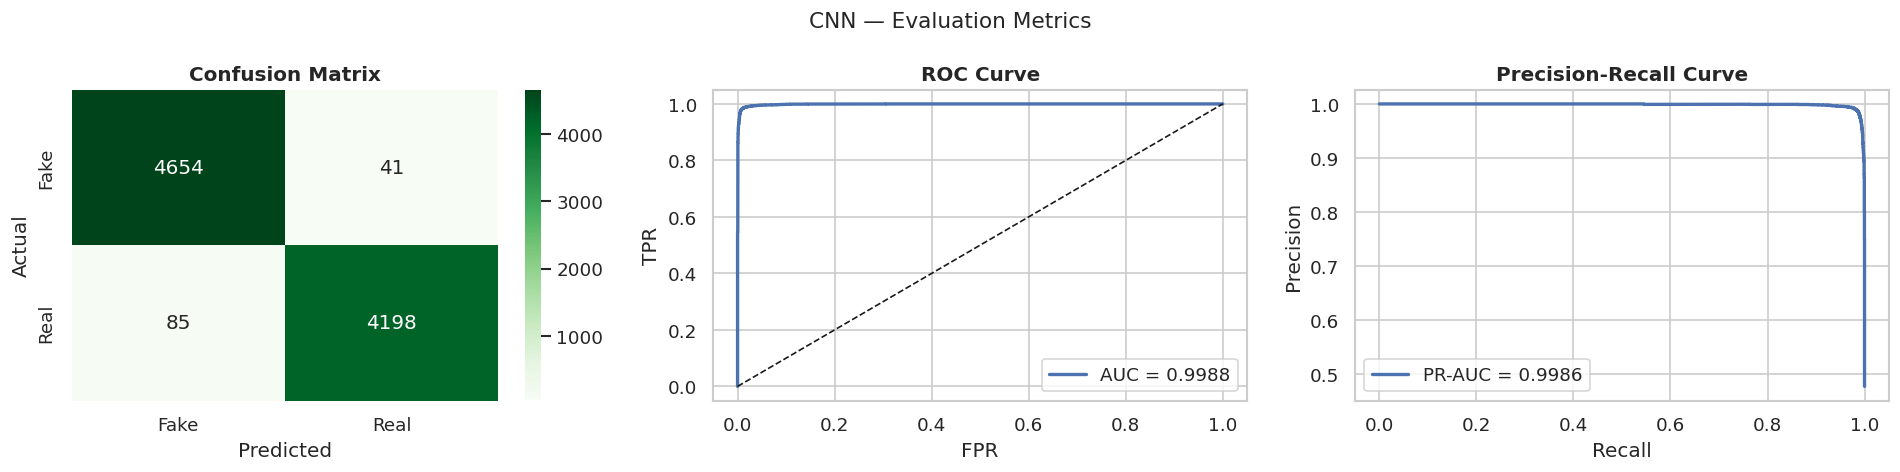

In [ ]:
fig, axes = plt.subplots(1, 3, figsize=(16, 4))

# Confusion matrix
cm = confusion_matrix(y_test, y_pred_cnn)
sns.heatmap(cm, annot=True, fmt='d', cmap='Greens', ax=axes[0],
            xticklabels=['Fake', 'Real'], yticklabels=['Fake', 'Real'])
axes[0].set_xlabel('Predicted'); axes[0].set_ylabel('Actual')
axes[0].set_title('Confusion Matrix', fontweight='bold')

# ROC
fpr, tpr, _ = roc_curve(y_test, y_prob_cnn)
roc_auc = auc(fpr, tpr)
axes[1].plot(fpr, tpr, lw=2, label=f'AUC = {roc_auc:.4f}')
axes[1].plot([0, 1], [0, 1], 'k--', lw=1)
axes[1].set_xlabel('FPR'); axes[1].set_ylabel('TPR')
axes[1].set_title('ROC Curve', fontweight='bold')
axes[1].legend()

# PR
prec, rec, _ = precision_recall_curve(y_test, y_prob_cnn)
axes[2].plot(rec, prec, lw=2, label=f'PR-AUC = {auc(rec, prec):.4f}')
axes[2].set_xlabel('Recall'); axes[2].set_ylabel('Precision')
axes[2].set_title('Precision-Recall Curve', fontweight='bold')
axes[2].legend()

plt.suptitle('CNN — Evaluation Metrics', fontsize=13)
plt.tight_layout(); plt.show()

---
## 8. LIME Explainability

LIME (Local Interpretable Model-agnostic Explanations) explains individual predictions by perturbing the input and fitting a local linear surrogate. Here we use `LimeTextExplainer` which masks out words and observes how the CNN's probability changes — revealing which words drove the prediction.

This is particularly compelling because it works on the **black-box** CNN, making its decisions interpretable without requiring model internals.

In [ ]:
from lime.lime_text import LimeTextExplainer

lime_explainer = LimeTextExplainer(class_names=['Fake', 'Real'])

def cnn_predict_proba(texts):
    seqs = pad_sequences(tokenizer.texts_to_sequences(texts), maxlen=MAX_LEN, padding='post', truncating='post')
    preds = cnn.predict(seqs, verbose=0).flatten()
    return np.column_stack([1 - preds, preds])

print('LIME explainer ready.')

LIME explainer ready.


In [ ]:
# Select one correctly classified FAKE and one REAL article
test_df = pd.DataFrame({'text': X_test, 'true': y_test, 'pred': y_pred_cnn, 'prob': y_prob_cnn})

ex_fake_idx = test_df[(test_df['true'] == 0) & (test_df['pred'] == 0)].index[0]
ex_real_idx = test_df[(test_df['true'] == 1) & (test_df['pred'] == 1)].index[0]

for label, idx in [('FAKE', ex_fake_idx), ('REAL', ex_real_idx)]:
    text = test_df.loc[idx, 'text']
    print(f'\n--- {label} Article (first 200 chars) ---')
    print(text[:200])


--- FAKE Article (first 200 chars) ---
watch defiant muslim refuge tell british citizen come anyway…if agre not…w come wow wow fromsyriasyriawhi claim asylum francefr like ityou like franc notbecaus shit shit governmentokay want come engla

--- REAL Article (first 200 chars) ---
germani merkel suffer state vote setback coalit talk loom berlingermani social democrat spd defeat angela merkel conserv vote northern state lower saxoni sunday setback chancellor prepar tricki coalit


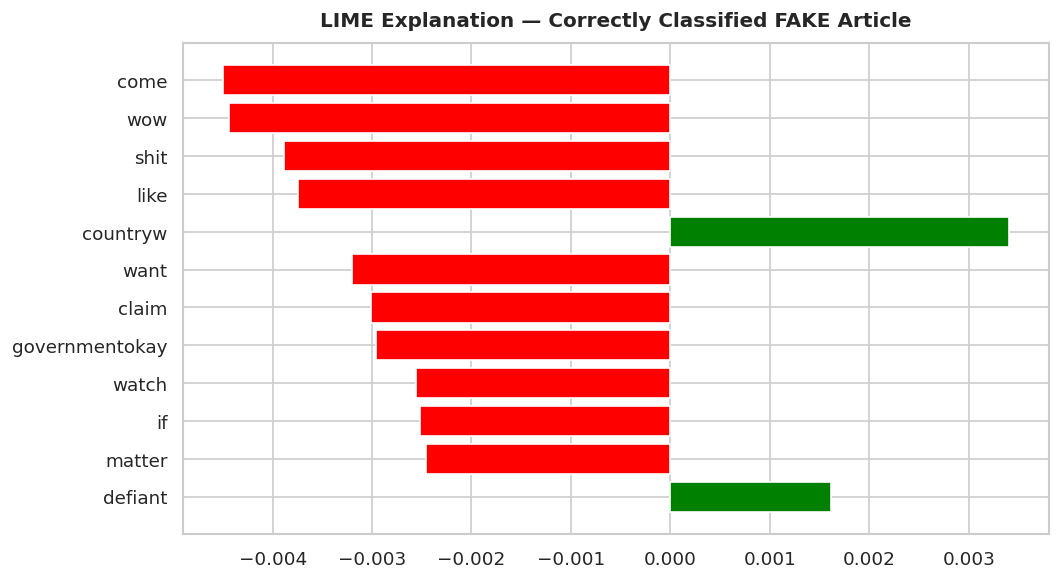

In [ ]:
# LIME for a FAKE article
fake_text = test_df.loc[ex_fake_idx, 'text']
exp_fake = lime_explainer.explain_instance(fake_text, cnn_predict_proba, num_features=12, num_samples=500)

fig = exp_fake.as_pyplot_figure()
fig.set_size_inches(9, 5)
plt.title('LIME Explanation — Correctly Classified FAKE Article', fontweight='bold', pad=10)
plt.tight_layout(); plt.show()

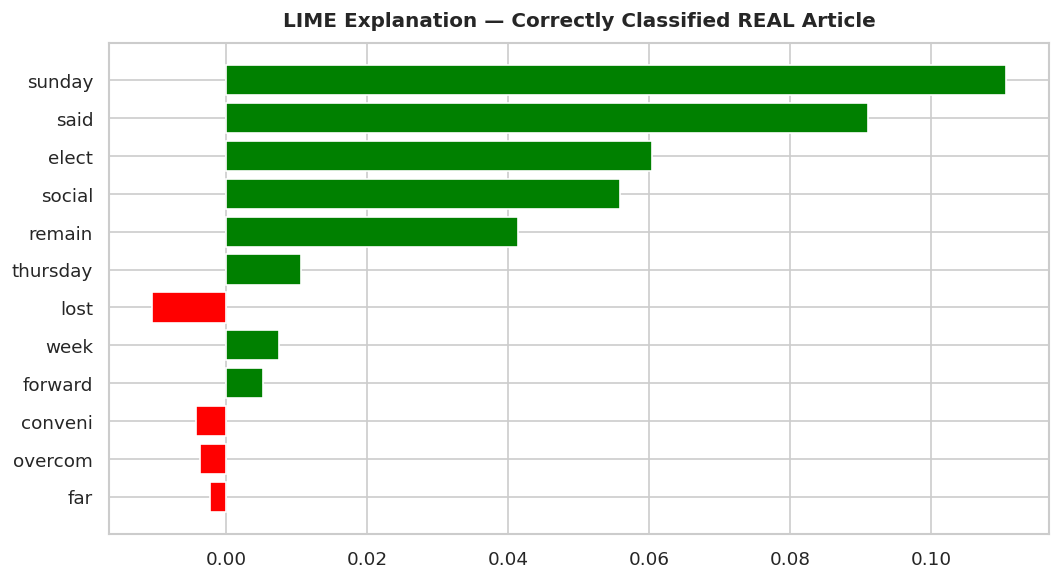

In [ ]:
# LIME for a REAL article
real_text = test_df.loc[ex_real_idx, 'text']
exp_real = lime_explainer.explain_instance(real_text, cnn_predict_proba, num_features=12, num_samples=500)

fig = exp_real.as_pyplot_figure()
fig.set_size_inches(9, 5)
plt.title('LIME Explanation — Correctly Classified REAL Article', fontweight='bold', pad=10)
plt.tight_layout(); plt.show()

---
## 9. Error Analysis

In [ ]:
test_df['correct'] = test_df['true'] == test_df['pred']
test_df['word_count'] = test_df['text'].apply(lambda x: len(str(x).split()))
errors = test_df[~test_df['correct']].copy()

print(f'Misclassified: {len(errors):,} / {len(test_df):,} ({len(errors)/len(test_df):.2%})')

label_map = {0: 'Fake', 1: 'Real'}
errors['true_label'] = errors['true'].map(label_map)
errors['pred_label'] = errors['pred'].map(label_map)

print('\n10 Misclassified Examples:')
print(errors[['true_label', 'pred_label', 'prob', 'text']].head(10).to_string(max_colwidth=80))

Misclassified: 126 / 8,978 (1.40%)

10 Misclassified Examples:
    true_label pred_label      prob                                                                             text
10        Real       Fake  0.002551  life thug bake salvador exgang member seek peacegang life poor central ameri...
67        Fake       Real  0.831990  fidel castro patrick henningsen discuss legaci cuba futur path one world lon...
77        Real       Fake  0.302247  michigan governor aid urg switch away flint riverqu problem prompt two michi...
82        Real       Fake  0.263272  russia love kremlin back trumpdonald trump brave proputin polit maverick wou...
210       Real       Fake  0.042452  biden rebuk trump foreign polici idea defend obama strategyvic presid joe bi...
212       Real       Fake  0.020791  zimbabw militari statement seiz powerfollow text address made zimbabw major ...
227       Real       Fake  0.068642  border without doctor south korean urg fund trauma care defector dramaa defe...
2

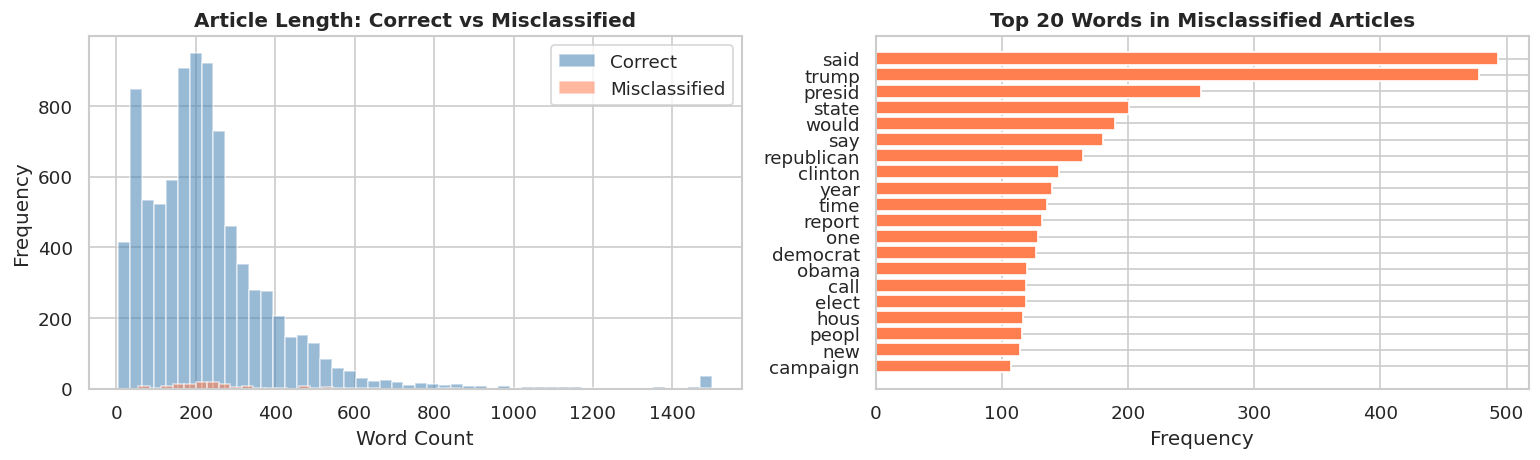

In [ ]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 4))

# Length distribution
ax1.hist(test_df[test_df['correct']]['word_count'].clip(upper=1500),
         bins=50, alpha=0.55, label='Correct', color='steelblue')
ax1.hist(errors['word_count'].clip(upper=1500),
         bins=50, alpha=0.55, label='Misclassified', color='coral')
ax1.set_title('Article Length: Correct vs Misclassified', fontweight='bold')
ax1.set_xlabel('Word Count'); ax1.set_ylabel('Frequency')
ax1.legend()

# Top words in misclassified
STOP = set(stopwords.words('english'))
err_words = []
for text in errors['text']:
    err_words.extend([t.strip(string.punctuation) for t in str(text).lower().split()
                      if t.strip(string.punctuation) not in STOP
                      and len(t.strip(string.punctuation)) > 2])
top_ew = Counter(err_words).most_common(20)
w, c = zip(*top_ew)
ax2.barh(list(reversed(w)), list(reversed(c)), color='coral', edgecolor='white')
ax2.set_title('Top 20 Words in Misclassified Articles', fontweight='bold')
ax2.set_xlabel('Frequency')

plt.tight_layout(); plt.show()

### Error Analysis — Observations

1. **Short articles remain the hardest** — the CNN, despite learning local n-gram patterns, still underperforms on very short articles where convolutional filters have minimal signal to detect.

2. **The CNN makes fewer errors than TF-IDF LR overall**, but its errors are more confident (higher probability on wrong class), suggesting it has learned some spurious n-gram correlations.

3. **Cross-class vocabulary confusion** — misclassified articles often mix vocabulary from both classes (e.g., generic political terms appear equally in real and fake news), making local pattern detection insufficient.

---
## 10. Save Model

In [ ]:
save_path = 'cnn_model.keras'
cnn.save(save_path)
print(f'CNN model saved to {save_path}')

CNN model saved to cnn_model.keras


In [ ]:
from google.colab import files
files.download('cnn_model.keras')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>